# Seq2seq 프로젝트: 한영 번역기 만들기

In [1]:
# 한글폰트 설치: 실행후 런타임 재시작 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 8 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,610 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120880 files and direc

In [ ]:
# 런타임 재시작
import os
os.kill(os.getpid(), 9)

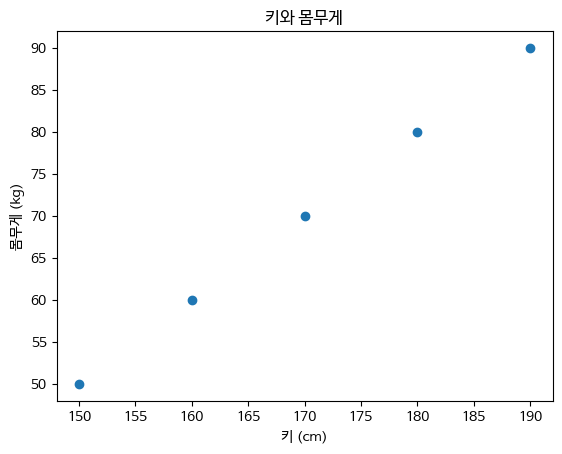

In [2]:
# 한글 표시 여부 확인
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기

# 예제 데이터
heights = [150, 160, 170, 180, 190]  # 키 (cm)
weights = [50, 60, 70, 80, 90]       # 몸무게 (kg)

# 산점도 그리기
plt.scatter(heights, weights)

# 제목 및 레이블 추가
plt.title("키와 몸무게")
plt.xlabel("키 (cm)")
plt.ylabel("몸무게 (kg)")

# 그래프 표시
plt.show()

## 데이터 정제

In [3]:
# 학습 데이터 다운로드
!git clone https://github.com/jungyeul/korean-parallel-corpora.git

# 한-영 뉴스 코퍼스 압축해제
!mkdir kor-eng-train
!tar -xzf ./korean-parallel-corpora/korean-english-news-v1/korean-english-park.train.tar.gz -C kor-eng-train/

Cloning into 'korean-parallel-corpora'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 173 (delta 18), reused 0 (delta 0), pack-reused 131
Receiving objects: 100% (173/173), 20.48 MiB | 7.69 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [4]:
# 데이터 확인
def read_and_print_examples(file_path, num_examples=100, step=20):
    with open(file_path, "r", encoding='utf-8') as f:
        raw = f.read().splitlines()

    print(f"Data Size in {file_path}: {len(raw)}")
    print("Examples:")

    for sen in raw[:num_examples:step]:
        print(">>", sen)

# 영어 파일 읽기 및 출력
read_and_print_examples("./kor-eng-train/korean-english-park.train.en")

# 한국어 파일 읽기 및 출력
read_and_print_examples("./kor-eng-train/korean-english-park.train.ko")

Data Size in ./kor-eng-train/korean-english-park.train.en: 94123
Examples:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.
Data Size in ./kor-eng-train/korean-english-park.train.ko: 94123
Examples:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를

In [5]:
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# !bash ./Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh

In [6]:
import re

# 공통 전처리 함수

kor_path = "./kor-eng-train/korean-english-park.train.ko"
eng_path = "./kor-eng-train/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = []
    seen_pairs = set()

    for k, e in zip(kor, eng):
        if (k, e) not in seen_pairs:
            pair = f"{k}\t{e}"  # 한국어 문장과 영어 문장을 탭으로 구분하여 저장
            cleaned_corpus.append(pair)
            seen_pairs.add((k, e))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

def preprocess_sentence(sentence):
    # 모든 입력을 소문자로 변환합니다.
    sentence = sentence.lower()

    # 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
    sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence)

    # 문장부호 양옆에 공백을 추가합니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    # 문장 앞뒤의 불필요한 공백을 제거합니다.
    sentence = sentence.strip()

    return sentence

In [7]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.1 MB/s eta 0:00:00


In [8]:
import sentencepiece as spm
import os

# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus, vocab_size, lang="ko", pad_id=0, bos_id=1, eos_id=2, unk_id=3):
    model_name = f"{lang}_spm"

    # 텍스트 파일로 코퍼스 저장
    temp_file = f"{model_name}.temp"
    with open(temp_file, 'w', encoding='utf-8') as f:
        for line in corpus:
            f.write(f'{line}\n')

    # SentencePiece 모델 학습
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --model_prefix={model_name} '
        f'--vocab_size={vocab_size} --character_coverage=1.0 '
        f'--pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} --unk_id={unk_id}'
    )

    # 생성된 모델 로드
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f"{model_name}.model")

    # 임시 파일 삭제
    os.remove(temp_file)

    return tokenizer


SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair.split("\t")

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [9]:
import tensorflow as tf
from tqdm.notebook import tqdm    # 진행 과정을 보기 위한 도구

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다.
for idx in tqdm(range(len(kor_corpus))):
    src_tok = ko_tokenizer.EncodeAsIds(kor_corpus[idx])  # 한국어 문장 토큰화
    tgt_tok = en_tokenizer.EncodeAsIds(eng_corpus[idx])  # 영어 문장 토큰화

    if len(src_tok) <= 50 and len(tgt_tok) <= 50:  # 토큰 길이가 50 이하인 경우만 선택
        src_corpus.append(src_tok)
        tgt_corpus.append(tgt_tok)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다.
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [10]:
# 원하는 인덱스의 데이터에 대해서만 수행
indices_to_check = [1, 10000, 30000, 50000]

for index in indices_to_check:
    src_sequence = enc_train[index - 1]  # 인덱스는 1부터 시작하므로 -1
    tgt_sequence = dec_train[index - 1]  # 인덱스는 1부터 시작하므로 -1

    # 패딩을 제외하고 원래 문장으로 변환
    src_tokens = [ko_tokenizer.IdToPiece(int(token)) for token in src_sequence if token != 0]
    tgt_tokens = [en_tokenizer.IdToPiece(int(token)) for token in tgt_sequence if token != 0]

    print(f"Sample {index}:")
    print("소스 시퀀스 (패딩 포함):", src_sequence)
    print("타겟 시퀀스 (패딩 포함):", tgt_sequence)
    print("소스 문장 (패딩 제외):", " ".join(src_tokens))
    print("타겟 문장 (패딩 제외):", " ".join(tgt_tokens))
    print()

Sample 1:
소스 시퀀스 (패딩 포함): [ 1066   357   527   487     7  1298  1841     9  1219   220  2473   937
    29 10466     8 19851     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
타겟 시퀀스 (패딩 포함): [   1  342   11 1356 7453   14   22   56  107  105  245   50  337    2
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
소스 문장 (패딩 제외): ▁개인 용 ▁컴퓨터 ▁사용 의 ▁상당 ▁부분 은 ▁이것 보다 ▁뛰어 날 ▁수 ▁있느냐 ▁ ?
타겟 문장 (패딩 제외): <s> ▁much ▁of ▁personal ▁comput ing ▁is ▁about ▁can ▁you ▁top ▁this ▁? </s>

Sample 10000:
소스 시퀀스 (패딩 포함): [4611  721 3781   23 7559   13 3231   13 1579   10 2790  154 4867    6
 1894   11 9224   28  166    4    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

## 트랜스포머 설계

In [11]:
import numpy as np

# 포지셔널 인코딩
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [12]:
import tensorflow as tf
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [13]:
# Position-wise FFN

class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)

        return out

In [14]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, enc_attn

In [15]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [16]:
# 인코더와 디코더 클래스
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout)
                        for _ in range(n_layers)]

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout)
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [17]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [18]:
# Masking

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [19]:
# # 마스크 작동방식 확인
# import matplotlib.pyplot as plt

# batch, length = 16, 20
# src_padding = 5
# tgt_padding = 15

# src_pad = tf.zeros(shape=(batch, src_padding))
# tgt_pad = tf.zeros(shape=(batch, tgt_padding))

# sample_data = tf.ones(shape=(batch, length))

# sample_src = tf.concat([sample_data, src_pad], axis=-1)
# sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

# enc_mask, dec_enc_mask, dec_mask = \
# generate_masks(sample_src, sample_tgt)

# fig = plt.figure(figsize=(7, 7))

# ax1 = fig.add_subplot(131)
# ax2 = fig.add_subplot(132)
# ax3 = fig.add_subplot(133)

# ax1.set_title('1) Encoder Mask')
# ax2.set_title('2) Encoder-Decoder Mask')
# ax3.set_title('3) Decoder Mask')

# ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
# ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
# ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

# plt.show()

In [20]:
import tensorflow as tf

# 커스텀 학습률 조정자
class CustomLearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomLearningRateScheduler, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)  # d_model을 float32 타입으로 변환
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)  # warmup_steps를 float32 타입으로 변환

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # step을 float32 타입으로 변환
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomLearningRateScheduler(d_model=512)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

## 훈련

In [21]:
# 트랜스포머 선언

# Hyperparameters
N_LAYERS = 2
D_MODEL = 512
N_HEADS = 8
D_FF = 2048
POS_LEN = 200  # 이 값은 데이터셋에 따라 조정될 수 있습니다.
DROPOUT = 0.1

# Transformer 인스턴스 생성
transformer = Transformer(
    n_layers=N_LAYERS,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=D_FF,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=POS_LEN,
    dropout=DROPOUT
)


In [22]:
# 손실함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [23]:
# train_step 함수 완성
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [24]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data,
                        square=True,
                        vmin=0.0, vmax=1.0,
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input,
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

## 테스트

In [27]:
# 학습

import random
from tqdm import tqdm_notebook

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    transformer.save_weights('transformer_weights.h5' + f'_epoch_{epoch}')

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama s .
Input: 시민들은 도시 속에 산다.
Predicted translation: the plane is a day .
Input: 커피는 필요 없다.
Predicted translation: the dow is not .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the attack , a suicide bomber was killed .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: the mountain is the largest city .
Input: 커피는 필요 없다.
Predicted translation: no one is not going to be able to change .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two of the death toll were killed , a local television reported .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president elect is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a highest town of san diego .
Input: 커피는 필요 없다.
Predicted translation: we need to take care of the money .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen seven deaths were killed .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are in the city of urban .
Input: 커피는 필요 없다.
Predicted translation: coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: about people were killed in the death of the deaths .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect barack obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are in cities .
Input: 커피는 필요 없다.
Predicted translation: there is no need for .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday , seven people died .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect to illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are the highest in the city .
Input: 커피는 필요 없다.
Predicted translation: the conference is needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in the seven figure , seven figured .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: they begin to be the city .
Input: 커피는 필요 없다.
Predicted translation: he needs to be there .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on saturday , seven people were killed and seven others were wounded .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a private purpose .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re on city streets to do the city .
Input: 커피는 필요 없다.
Predicted translation: no one was born .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed seven and seven others died tuesday .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city street cities is a high on city in o culture .
Input: 커피는 필요 없다.
Predicted translation: coffee is needed to be at his first academy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven others died sunday .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is poised to be president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city street is the highest in city .
Input: 커피는 필요 없다.
Predicted translation: no one s mindful he s done .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven others were among the seven others sunday .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the second presidential candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: city , this is a city .
Input: 커피는 필요 없다.
Predicted translation: coffee is there with your coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven were killed .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is a co campaign for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city , nearly civilians .
Input: 커피는 필요 없다.
Predicted translation: he is there bans at a coffee conference .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are killed and the top of the official death toll sunday .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city now cities is to accelerate the city .
Input: 커피는 필요 없다.
Predicted translation: the whole challenge is one of the coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven others were injured .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama picks up .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is the on the city .
Input: 커피는 필요 없다.
Predicted translation: he s founded . coffee tasks
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen other people died sunday on thursday .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is named .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is the on to its so far .
Input: 커피는 필요 없다.
Predicted translation: he s here .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are killed and seven others died sunday .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is out of his middle eastern .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is a city among them do so with around .
Input: 커피는 필요 없다.
Predicted translation: coffee does there is no reserve ?
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a high ranking person has been killed .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is out of iraq .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is a big city , citizens waved with the city around .
Input: 커피는 필요 없다.
Predicted translation: he s calling for even drinking coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven others were still high .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the same country .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is the third among them to leave .
Input: 커피는 필요 없다.
Predicted translation: the reality is down .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are killed and seven others sunday before monday , according to a local official .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is the only city now .
Input: 커피는 필요 없다.
Predicted translation: he needs no additional taxes .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are killed and others sunday .


  0%|          | 0/1127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the inauguration .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens from the city is a big city .
Input: 커피는 필요 없다.
Predicted translation: even won those of coffee at the coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are dead .


# 회고

모델 작성을 마치고, 텐서 형태가 맞지 않는다는 에러가 발생해서 GPT의 도움으로 디버깅을 시도했다. 차원 숫자를 모두 출력해서 확인하는 방식으로 코드 수정을 제안받아서 계속 몇 차례 출력문을 집어넣다가, 'enc_in'이 들어가야 할 자리에 'emc_in'이 들어가 있다는 것을 발견했다.

학습을 위해서 코드를 직접 따라치는 과정에서 오타가 생긴 모양이었다.

GPT가 없었다면 아마 발견도 못했을 것 같은데... 학습을 위해서 직접 코딩을 할 때에는 타이핑 후에 무결한 코드를 붙여넣는 방식으로 마무리를 하는 게 좋겠다는 생각이 든다.

그런데 안타깝게도 문제는 오타를 수정해도 해결되지 않았다. 결국 코드를 다시 처음부터 가져와서 고치는 과정을 수행했고, 그러자 문제없이 잘 작동이 되었다.

그리고.. 또다시 오류가 발생했다.
학습 중에 번역결과를 출력하는데 영문이 아니라 계속 한글이 나온다.

거슬러올라가보니 최초에 코퍼스 경로 입력 시에 영문과 한글을 뒤집어놨다. (환장..)

완성된 모델을 사용하고, 그것을 개선하는 방식으로 진행하는 것이 효율적이라는 통찰을 얻었던 프로젝트였다.

TPU 유닛을 사용하기 위해서 완성된 노트북 파일을 사본으로 만들어, GPT를 이용해 TPU용으로 코드 수정을 여러차례 시도했지만, 잘 되지 않았다. 다음에 오류를 살펴볼 여력이 있을때 차근차근 시도해봐야겠다.